In [1]:
"""
In this exercise we will train some neural network using Pytorch.
Installation instructions: https://pytorch.org/get-started/locally/

I recommend to run this exercise in colab using GPU or in kaggle notebooks.
You should find something like: Runtime -> Change runtime type -> T4 GPU to access GPU there.
Everything thing you need is preinstalled there.
"""

'\nIn this exercise we will train some neural network using Pytorch.\nInstallation instructions: https://pytorch.org/get-started/locally/\n\nI recommend to run this exercise in colab using GPU or in kaggle notebooks.\nYou should find something like: Runtime -> Change runtime type -> T4 GPU to access GPU there.\nEverything thing you need is preinstalled there.\n'

In [2]:
# Because outside world is ugly (in console 'export OMP_NUM_THREADS=1')
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
# Pytorch is library for dealing with neural networks (and automatic gradients)
import torch
import torch.nn as nn
import torch.nn.functional as F
# Torchvision is helper library for pytorch to deal with computer vision
import torchvision

import matplotlib.pyplot as plt

In [4]:
"""Prepare dataset, whole lecture will be done over MNIST dataset"""
batch_size_train = 256
batch_size_test = 1024

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

/home/usamec/anaconda3/envs/magic_train/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# What is in train?
for x, y in train_loader:
    print(x.shape, y.shape, y[:10])
    break

torch.Size([256, 1, 28, 28]) torch.Size([256]) tensor([0, 3, 9, 0, 5, 3, 7, 1, 5, 1])


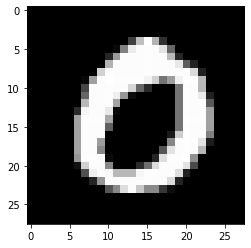

In [6]:
# X: 256 images, 1 channel (black/white), 28x28 image
# We will flatten each image into one vector for now
# Y: One number (category of image)
# Images looks like this:

plt.imshow(x[0,0], cmap="gray")

In [7]:
# Simple linear model (multiclass logistic regression)
# This just computes scores for each class
# This layer has parameters W, b and does (input.matmul(W.T) + b)
model_linear = nn.Linear(28*28, 10)
[(name, p.shape) for name, p in model_linear.named_parameters()]

[('weight', torch.Size([10, 784])), ('bias', torch.Size([10]))]

In [8]:
# Let's compute loss for one batch of images
output = model_linear(x.flatten(1))
log_probs = F.log_softmax(output, dim=-1)    # log_softmax(.) = log(softmax(.))
loss = F.nll_loss(log_probs, y)
loss

tensor(2.4424, grad_fn=<NllLossBackward>)

In [9]:
# Pytorch has many loss functions, which look similar but take different things,
# so take care
# Here cross entropy(output, y) is same as nll_loss(log_softmax(output), y)
loss2 = F.cross_entropy(output, y)
loss2

tensor(2.4424, grad_fn=<NllLossBackward>)

In [10]:
# If we want to train model, we need to get gradients
# This is easy, gradient will magically appear
loss.backward()
model_linear.weight.grad

# If you really want to do things by hand
# model_linear.weight.data = model_linear.weight.data - 0.01 * model_linear.weight.grad

tensor([[ 0.0137,  0.0137,  0.0137,  ...,  0.0137,  0.0137,  0.0137],
        [ 0.0080,  0.0080,  0.0080,  ...,  0.0080,  0.0080,  0.0080],
        [ 0.0164,  0.0164,  0.0164,  ...,  0.0164,  0.0164,  0.0164],
        ...,
        [ 0.0017,  0.0017,  0.0017,  ...,  0.0017,  0.0017,  0.0017],
        [ 0.0049,  0.0049,  0.0049,  ...,  0.0049,  0.0049,  0.0049],
        [-0.0107, -0.0107, -0.0107,  ..., -0.0107, -0.0107, -0.0107]])

In [11]:
# If we calculate gradient second time, it will accumulate
output = model_linear(x.flatten(1))
log_probs = F.log_softmax(output, dim=-1)    # log_softmax(.) = log(softmax(.))
loss = F.nll_loss(log_probs, y)
loss.backward()
model_linear.weight.grad

tensor([[ 0.0274,  0.0274,  0.0274,  ...,  0.0274,  0.0274,  0.0274],
        [ 0.0160,  0.0160,  0.0160,  ...,  0.0160,  0.0160,  0.0160],
        [ 0.0329,  0.0329,  0.0329,  ...,  0.0329,  0.0329,  0.0329],
        ...,
        [ 0.0034,  0.0034,  0.0034,  ...,  0.0034,  0.0034,  0.0034],
        [ 0.0098,  0.0098,  0.0098,  ...,  0.0098,  0.0098,  0.0098],
        [-0.0215, -0.0215, -0.0215,  ..., -0.0215, -0.0215, -0.0215]])

In [12]:
# Lets optimize, this is typical pytorch training loop you will see a lot with some modifications
model_linear = nn.Linear(28*28, 10)
optimizer = torch.optim.SGD(model_linear.parameters(), lr=1)

for epoch in range(5):
    total_loss = 0
    total_loss_cc = 0
    for x, y in train_loader:
        # Here we calculate output from the model, note that we flatten the input (converts 256,1,28,28 to 256,784) 
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        # Here we calculate loss
        batch_loss = F.nll_loss(log_probs, y)
        # Here we calculate gradients, first we need to zero previous ones
        optimizer.zero_grad()
        batch_loss.backward()
        # And here we update the weights
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
    print("epoch", epoch, "training loss", total_loss / total_loss_cc)

epoch 0 training loss 2.00052149207034
epoch 1 training loss 1.2760408939199244
epoch 2 training loss 1.191791332148491
epoch 3 training loss 1.1462283043151207
epoch 4 training loss 1.0351847174319815


In [13]:
# Optimize and compute training accuracy and test accuracy

model_linear = nn.Linear(28*28, 10)
optimizer = torch.optim.SGD(model_linear.parameters(), lr=1)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        # This calulcates accuracy
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        output = model_linear(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))

epoch 0 training loss 1.951 training accuracy 0.834 testing accuracy 0.880
epoch 1 training loss 1.338 training accuracy 0.871 testing accuracy 0.859
epoch 2 training loss 1.168 training accuracy 0.878 testing accuracy 0.871
epoch 3 training loss 1.191 training accuracy 0.878 testing accuracy 0.882
epoch 4 training loss 1.085 training accuracy 0.880 testing accuracy 0.874
epoch 5 training loss 1.052 training accuracy 0.885 testing accuracy 0.819
epoch 6 training loss 1.052 training accuracy 0.884 testing accuracy 0.892
epoch 7 training loss 1.063 training accuracy 0.885 testing accuracy 0.887
epoch 8 training loss 1.039 training accuracy 0.885 testing accuracy 0.865
epoch 9 training loss 1.050 training accuracy 0.885 testing accuracy 0.907


In [14]:
# This is how you define a simple neural network in Pytorch

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

model(torch.randn((10,28*28)))

tensor([[ 0.0388,  0.1307, -0.2220,  0.0209, -0.0893, -0.2690, -0.1389, -0.2647,
         -0.0757, -0.2917],
        [-0.2254,  0.0284,  0.1106, -0.3431, -0.1479, -0.2410,  0.1822,  0.0154,
          0.2372,  0.0017],
        [ 0.3014, -0.1125,  0.1806,  0.1344,  0.2504,  0.1933, -0.0045, -0.2011,
          0.3596,  0.0291],
        [-0.1752,  0.2518, -0.3156, -0.1780, -0.0343, -0.1783,  0.0321, -0.2541,
          0.3890, -0.7036],
        [-0.0637, -0.1810, -0.1249, -0.2442, -0.4494, -0.2623, -0.2865, -0.2943,
          0.2449, -0.6921],
        [-0.3282, -0.2350, -0.4335,  0.0862, -0.0895, -0.3210,  0.6854, -0.2567,
         -0.2212, -0.3431],
        [-0.3149, -0.0967, -0.1309, -0.1375, -0.4409,  0.0913,  0.1726, -0.0405,
          0.7088, -0.4498],
        [-0.1807,  0.1501,  0.0303,  0.1532,  0.1420, -0.3575,  0.1475,  0.1872,
          0.3412, -0.1423],
        [-0.4604, -0.3253,  0.1288, -0.2578,  0.2968, -0.1051,  0.0454, -0.0824,
         -0.0895, -0.1224],
        [-0.1738, -

In [15]:
# Let's train neural network, we only change model and maybe learning rate

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.0)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        output = model(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        output = model(x.flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))

epoch 0 training loss 1.794 training accuracy 0.457 testing accuracy 0.406
epoch 1 training loss 1.351 training accuracy 0.503 testing accuracy 0.566
epoch 2 training loss 1.137 training accuracy 0.627 testing accuracy 0.634
epoch 3 training loss 1.106 training accuracy 0.600 testing accuracy 0.654
epoch 4 training loss 1.098 training accuracy 0.590 testing accuracy 0.585
epoch 5 training loss 1.077 training accuracy 0.601 testing accuracy 0.710
epoch 6 training loss 0.785 training accuracy 0.730 testing accuracy 0.723
epoch 7 training loss 0.603 training accuracy 0.810 testing accuracy 0.807
epoch 8 training loss 0.433 training accuracy 0.881 testing accuracy 0.894
epoch 9 training loss 0.368 training accuracy 0.906 testing accuracy 0.898


In [16]:
"""
# How to run on cuda (this optional, if you have GPU access, e.g. in colab or kaggle notebooks)
# No need to run this cell

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
# Move model to GPU. Instead of x.cuda() you can also use x.to(device) where device is "cpu" or "cuda" so your code
# is nicely parametrized.

model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(10):
    total_loss = 0
    total_loss_cc = 0
    total_good = 0
    total_samples = 0
    
    for x, y in train_loader:
        # Move input and labels to GPU
        output = model(x.cuda().flatten(1))
        y = y.cuda()
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good += (prediction == y).sum().item()
        total_samples += y.shape[0]
        
        batch_loss = F.nll_loss(log_probs, y)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        total_loss_cc += 1
        
    total_good_test = 0
    total_samples_test = 0
    for x, y in test_loader:
        # Move input and labels to GPU
        y = y.cuda()
        output = model(x.cuda().flatten(1))
        log_probs = F.log_softmax(output, dim=-1)
        
        prediction = log_probs.argmax(dim=-1)
        total_good_test += (prediction == y).sum().item()
        total_samples_test += y.shape[0]
        
    print("epoch", epoch, "training loss %.3f" % (total_loss / total_loss_cc), 
          "training accuracy %.3f" % (total_good / total_samples), 
          "testing accuracy %.3f" % (total_good_test / total_samples_test))
          
"""

'\n# How to run on cuda (this optional, if you have GPU access, e.g. in colab or kaggle notebooks)\n# No need to run this cell\n\nmodel = nn.Sequential(\n    nn.Linear(28*28, 256),\n    nn.ReLU(),\n    nn.Linear(256, 10)\n)\n# Move model to GPU. Instead of x.cuda() you can also use x.to(device) where device is "cpu" or "cuda" so your code\n# is nicely parametrized.\n\nmodel.cuda()\noptimizer = torch.optim.SGD(model.parameters(), lr=0.1)\n\nfor epoch in range(10):\n    total_loss = 0\n    total_loss_cc = 0\n    total_good = 0\n    total_samples = 0\n    \n    for x, y in train_loader:\n        # Move input and labels to GPU\n        output = model(x.cuda().flatten(1))\n        y = y.cuda()\n        log_probs = F.log_softmax(output, dim=-1)\n        \n        prediction = log_probs.argmax(dim=-1)\n        total_good += (prediction == y).sum().item()\n        total_samples += y.shape[0]\n        \n        batch_loss = F.nll_loss(log_probs, y)\n        optimizer.zero_grad()\n        batch_

In [17]:
"""
Task 1.
In example above figure out best settings for learning rate a momentum in the optimizer.
Keep the number of epochs to 10. Also keep the learning constant during training.
Sumarize your findings in some chart or table.
"""

'\nTask 1.\nIn example above figure out best settings for learning rate a momentum in the optimizer.\nKeep the number of epochs to 10. Also keep the learning constant during training.\nSumarize your findings in some chart or table.\n'

In [18]:
"""
Task 2.
Here is network with 2 hidden layers (each additional hidden layer we add nn.Linear(256,256) and nn.ReLU())

model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

How does adding more hidden layers influence final accuracy (try 3-6 hidden layers).
Always figure out the best optimizer settings. Again run for 10 epochs.
Again produce some chart or table (maybe with accuracy changes over time).
"""

'\nTask 2.\nHere is network with 2 hidden layers (each additional hidden layer we add nn.Linear(256,256) and nn.ReLU())\n\nmodel = nn.Sequential(\n    nn.Linear(28*28, 256),\n    nn.ReLU(),\n    nn.Linear(256, 256),\n    nn.ReLU(),\n    nn.Linear(256, 256),\n    nn.ReLU(),\n    nn.Linear(256, 10)\n)\n\nHow does adding more hidden layers influence final accuracy (try 3-6 hidden layers).\nAlways figure out the best optimizer settings. Again run for 10 epochs.\nAgain produce some chart or table (maybe with accuracy changes over time).\n'

In [19]:
"""
Here is an example of a simple convolutional network. They are really good on images.
E.g. ResNet is a very strong baseline for any image task https://pytorch.org/vision/main/models/resnet.html
Or convnext: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/convnext.py

model = nn.Sequential(
    nn.Conv2d(1, 16, 5, padding=2, stride=2),  # Here we get 14x14 image with 16 channels
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1, stride=2),  # Here we get 7x7 image with 32 channels
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding='same'),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(7*7*32, 10)
)
"""

"\nHere is an example of a simple convolutional network. They are really good on images.\nE.g. ResNet is a very strong baseline for any image task https://pytorch.org/vision/main/models/resnet.html\nOr convnext: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/convnext.py\n\nmodel = nn.Sequential(\n    nn.Conv2d(1, 16, 5, padding=2, stride=2),  # Here we get 14x14 image with 16 channels\n    nn.ReLU(),\n    nn.Conv2d(16, 16, 3, padding='same'),\n    nn.ReLU(),\n    nn.Conv2d(16, 32, 3, padding=1, stride=2),  # Here we get 7x7 image with 32 channels\n    nn.ReLU(),\n    nn.Conv2d(32, 32, 3, padding='same'),\n    nn.ReLU(),\n    nn.Flatten(),\n    nn.Linear(7*7*32, 10)\n)\n"

In [20]:
# We can also define neural networks as modules.
# This is same model as 
# model = nn.Sequential(
#    nn.Linear(28*28, 256),
#    nn.ReLU(),
#    nn.Linear(256, 10)
#)

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Linear(28*28, 256)
        self.b = nn.Linear(256, 10)
        
    def forward(self, x):
        x = self.a(x)
        x = torch.relu(x)
        x = self.b(x)
        return x
    
#model = MyModel()
#model(torch.rand(50, 28*28))

In [21]:
"""
Task 4:

Usually layers in neural networks need to be initialized with some random values (pytorch handles this for you).
If you initialize all layers to zeroes, network will not train.
But if you initialize only some of them to zeroes, network will train and all layers will get updated at some points of the training.
Your task is to figure out which layers you can initialize with zeroes.


Consider following two models (ModelA and ModelB).
Which layers in those models can be initialized to zeroes and model will still train
(that means: all layers will be updated at some point of the training)? 
Ideal answer should contain: theoretical justification and also experimental result (successful training)
"""

class ModelA(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Linear(28*28, 256, bias=False) # bias=False means, that transformation is xW instead of xW + b
        self.a.weight.data *= 0  # This sets weights of a to zero
        self.b = nn.Linear(256, 256, bias=False)
        self.b.weight.data *= 0  # This sets weights of b to zero
        self.c = nn.Linear(256, 10, bias=False)
        self.c.weight.data *= 0  # This sets weights of c to zero
        
    def forward(self, x):
        x = self.a(x)
        x = torch.relu(x)
        x = self.b(x)
        x = torch.relu(x)
        x = self.c(x)
        return x
    
class ModelB(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Linear(28*28, 256, bias=False)
        self.a.weight.data *= 0  
        self.b1 = nn.Linear(256, 256, bias=False)
        self.b1.weight.data *= 0 
        self.b2 = nn.Linear(256, 256, bias=False)
        self.b2.weight.data *= 0 
        self.c1 = nn.Linear(256, 256, bias=False)
        self.c1.weight.data *= 0 
        self.c2 = nn.Linear(256, 256, bias=False)
        self.c2.weight.data *= 0 
        self.o = nn.Linear(256, 10, bias=False)
        self.o.weight.data *= 0  
        
    def forward(self, x):
        x = self.a(x)
        z = torch.relu(x)
        z = self.b1(z)
        z = torch.relu(x)
        z = self.b2(z)
        x = x + z
        z = torch.relu(x)
        z = self.c1(z)
        z = torch.relu(x)
        z = self.c2(z)
        x = x + z
        x = self.o(x)
        return x